# setting

## path

In [1]:
import sys, os
home_path = os.path.expanduser("~")
sys.path.append(home_path + '/Desktop/Credit_Comp/py/models/')
sys.path.append(home_path + '/Desktop/Credit_Comp/py/')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages')
sys.path.append(home_path + '/.pyenv/versions/3.6.5/lib/python3.6/site-packages/xgboost-0.81-py3.6.egg')

## module

使用するモジュールをimport

In [38]:
import numpy as np # linear algebra
import pandas as pd # data processing
import pandas_profiling as pdp
from collections import Counter
import base, Classifier # my module
# optuna
from functools import partial
import optuna
# sklearn
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.externals.six import StringIO
# Boosting
from xgboost import XGBClassifier
import lightgbm as lgb
# view
import pydotplus
from IPython.display import Image
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

In [39]:
# moduleの再読み込み(作業中に更新した内容をここで更新できる)
import importlib
importlib.reload(base)
importlib.reload(Classifier)

<module 'Classifier' from '/Users/takuto/Desktop/Credit_Comp/py/models/Classifier.py'>

In [40]:
# for instance
Process = base.Process()
Applicate = base.Applicate()
LightGBM = Classifier.LightGBM()
DecisionTree = Classifier.DecisionTree()

## read data

In [14]:
# using data
train, test, target = Process.read_data1()

27000 observations and 24 features in train set.
3000 observations and 23 features in test set.


In [15]:
# select features
features = test.columns.values # 暫定的
category_features = [1,2,3,4,5,6,7,8,9,10]

# eda

In [6]:
# 欠損値の確認
Applicate.missing_value(train)

,y,X23,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X1
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# 簡単なレポート作成
profile = pdp.ProfileReport(train)
file_name = home_path + '/Desktop/Credit_Comp/output/report/train_data_profile.html'
profile.to_file(outputfile = file_name)

# Detail

## クレジット金額と支払い履行の関係性

少額を踏み倒している?

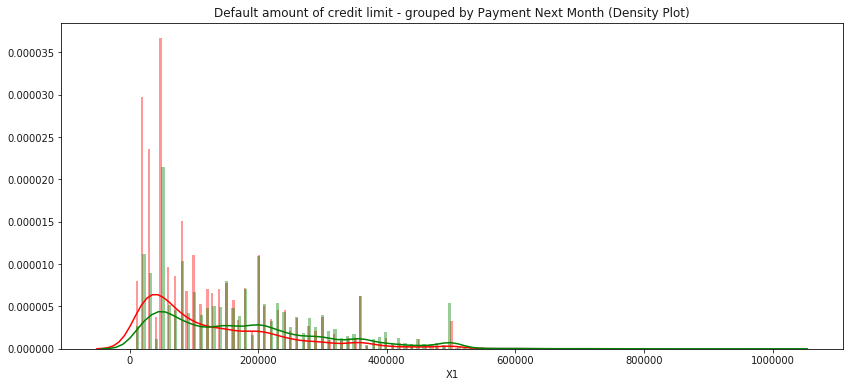

In [8]:
class_0 = train.loc[train['y'] == 0]['X1']
class_1 = train.loc[train['y'] == 1]['X1']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=200, color="red")
sns.distplot(class_0,kde=True,bins=200, color="green")
plt.show()

## 年齢と支払い履行の関係性

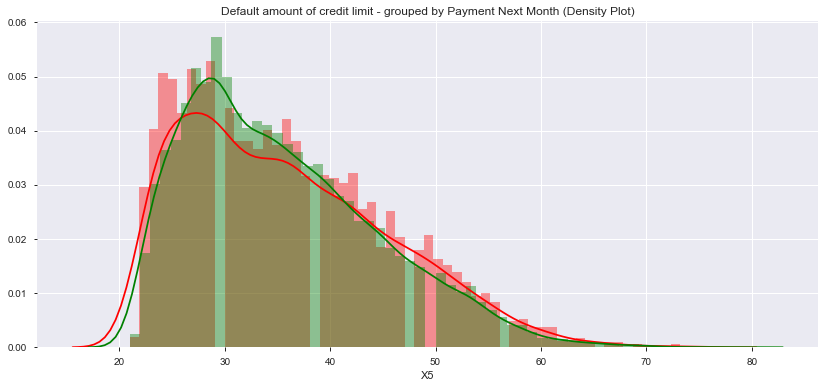

In [108]:
class_0 = train.loc[train['y'] == 0]['X5']
class_1 = train.loc[train['y'] == 1]['X5']
plt.figure(figsize = (14,6))
plt.title('Default amount of credit limit - grouped by Payment Next Month (Density Plot)')
sns.set_color_codes("pastel")
sns.distplot(class_1,kde=True,bins=60, color="red")
sns.distplot(class_0,kde=True,bins=60, color="green")
plt.show()

## カテゴリカル変数のクロス集計 

In [111]:
print("性別（1=男性, 2=女性)")
print(pd.crosstab(index=train["X2"],columns=train["y"]))
print("教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）")
print(pd.crosstab(index=train["X3"],columns=train["y"]))
print("婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）")
print(pd.crosstab(index=train["X4"],columns=train["y"]))

性別（1=男性, 2=女性)
y       0     1
X2             
1    8126  2591
2   12880  3403
教育（1=大学院, 2=大学, 3=高校, 0,4,5,6=その他）
y      0     1
X3            
0     12     0
1   7671  1834
2   9633  3013
3   3317  1117
4    105     6
5    226    18
6     42     6
婚姻状況（1=既婚, 2=単身, 3=離婚, 0=その他）
y       0     1
X4             
0      42     4
1    9402  2904
2   11348  3010
3     214    76


# Feature Correlation

## 支払い記録の相関

1ヶ月ごとに遅れていくので, 相関が生まれやすい

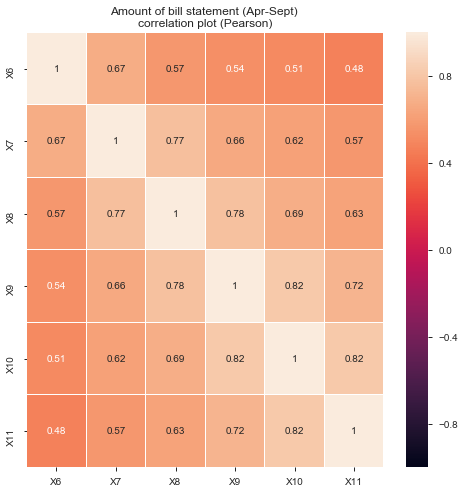

In [117]:
var = ["X6","X7","X8","X9","X10","X11"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

## 請求明細書の相関

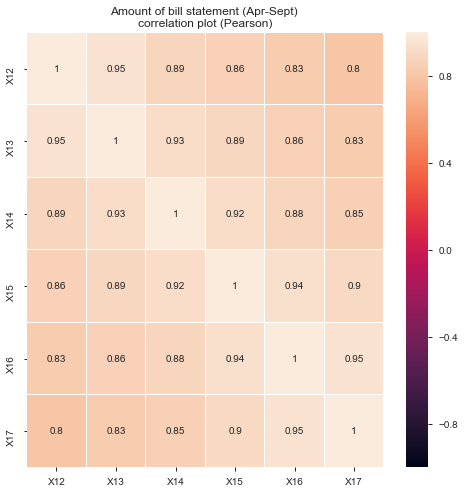

In [118]:
var = ["X12","X13","X14","X15","X16","X17"]
plt.figure(figsize = (8,8))
plt.title('Amount of bill statement (Apr-Sept) \ncorrelation plot (Pearson)')
corr = train[var].corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,vmin=-1, vmax=1,annot=True)
plt.show()

# Algorithm Selection

- 複数のモデル等を適用してみて, 今後の方針を考える.
- 関数化(Classifier.py)して, 適宜書き換える

## Decision tree

In [68]:
# execute model
param = {
    'random_state': 831,
    'max_depth': 5,
    'criterion': 'gini'
}
clf = DecisionTreeClassifier(**param)
clf = clf.fit(train.drop("y",axis=1), train["y"])
# predict value
predict = clf.predict(test)
predict
# sample submit
# Process.submit(predict,tech="simple_decision_tree")

array([0, 0, 0, ..., 0, 1, 0])

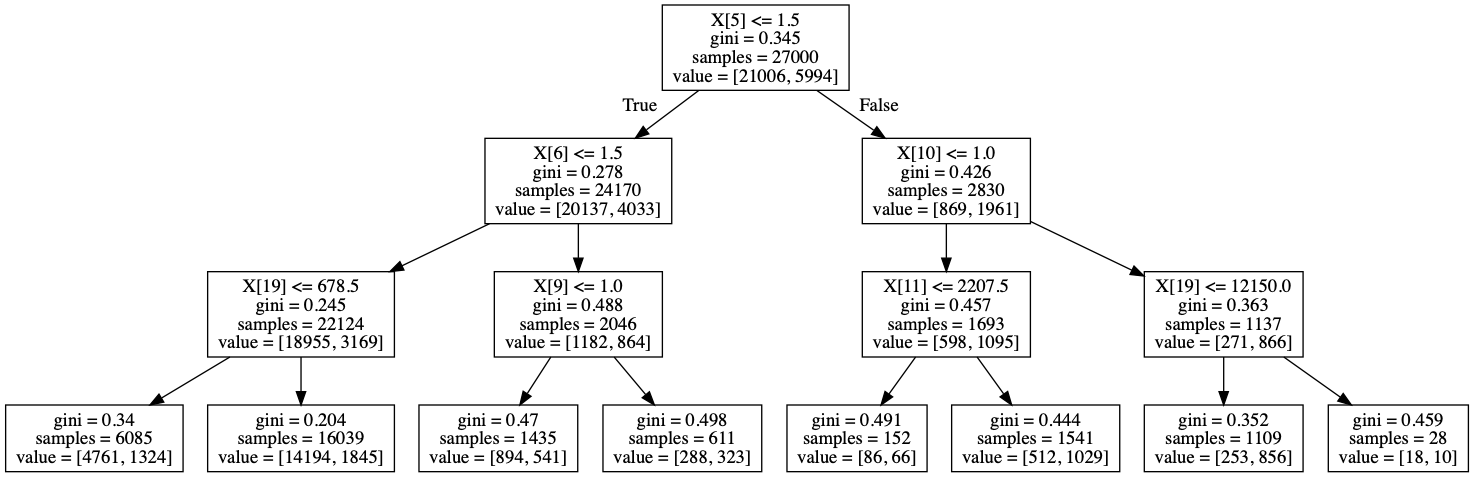

In [19]:
# tree view
DecisionTree.display_tree(clf)

## Compare Some Models

- DecisionTree
- RandamForest
- AdaBoost
- GradientBoosting
- XGBoost
- LightGBM

In [40]:
# classifier list for the normal training set
clf_list = [DecisionTreeClassifier(max_depth = 3, class_weight = "balanced"), 
            RandomForestClassifier(n_estimators = 100, class_weight = "balanced"), 
            AdaBoostClassifier(DecisionTreeClassifier(max_depth = 3,                
                                                      class_weight = "balanced"),
                               n_estimators = 100), 
            GradientBoostingClassifier(), 
            XGBClassifier()
           ]
# use Kfold to evaluate the normal training set
kf = KFold(n_splits=5,random_state=831,shuffle=True)

# ans box
ans = pd.DataFrame(columns=['model','fold','score'])

In [41]:
# validation some models classifier
for i,(trn_index, val_index) in enumerate(kf.split(train)):
    # set data
    training = train.iloc[trn_index][features]
    valid = train.iloc[val_index][features]
    trn_target = train.iloc[trn_index]['y']
    val_target = train.iloc[val_index]['y']
    # cross validation
    print("fold n°{}".format(i+1))
    for clf in clf_list:
        name = clf.__class__.__name__ # model name 
        clf.fit(training,trn_target) # model execute
        pred = clf.predict(valid) # predict validation
        score = f1_score(y_true = val_target, y_pred = pred) # score
        tmp = pd.Series( [name, i+1, score], index=ans.columns )
        ans = ans.append( tmp, ignore_index=True )
        print(name)
# result
print(ans)

fold n°1
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°2
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°3
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°4
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
fold n°5
DecisionTreeClassifier
RandomForestClassifier
AdaBoostClassifier
GradientBoostingClassifier


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


XGBClassifier
                         model fold     score
0       DecisionTreeClassifier    1  0.514390
1       RandomForestClassifier    1  0.460860
2           AdaBoostClassifier    1  0.492329
3   GradientBoostingClassifier    1  0.481888
4                XGBClassifier    1  0.476295
5       DecisionTreeClassifier    2  0.522108
6       RandomForestClassifier    2  0.466412
7           AdaBoostClassifier    2  0.510526
8   GradientBoostingClassifier    2  0.475780
9                XGBClassifier    2  0.474429
10      DecisionTreeClassifier    3  0.517328
11      RandomForestClassifier    3  0.448164
12          AdaBoostClassifier    3  0.510252
13  GradientBoostingClassifier    3  0.482315
14               XGBClassifier    3  0.478752
15      DecisionTreeClassifier    4  0.518016
16      RandomForestClassifier    4  0.442675
17          AdaBoostClassifier    4  0.497831
18  GradientBoostingClassifier    4  0.474895
19               XGBClassifier    4  0.474541
20      DecisionTree

In [7]:
# validation lightgbm classifier
param = Process.open_parameter(file_name = 'lgb_classifer_param')
lgb_ans, importances = LightGBM.validation(train,features,category_features,param)
print(lgb_ans)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.150231	valid_1's binary_error: 0.177037
[200]	training's binary_error: 0.121574	valid_1's binary_error: 0.178148
Early stopping, best iteration is:
[21]	training's binary_error: 0.173472	valid_1's binary_error: 0.17463
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.151065	valid_1's binary_error: 0.177778
[200]	training's binary_error: 0.122824	valid_1's binary_error: 0.179074
Early stopping, best iteration is:
[35]	training's binary_error: 0.169259	valid_1's binary_error: 0.175926
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.151389	valid_1's binary_error: 0.179815
[200]	training's binary_error: 0.120602	valid_1's binary_error: 0.182222
Early stopping, best iteration is:
[53]	training's binary_error: 0.163287	valid_1's binary_error: 0.178148
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.148056	valid_1's binary_error: 0.185926
[200]	training's binary_error: 0.121759	valid_1's binary_error: 0.18963
Early stopping, best iteration is:
[96]	training's binary_error: 0.148657	valid_1's binary_error: 0.184815
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.150463	valid_1's binary_error: 0.17963
[200]	training's binary_error: 0.122361	valid_1's binary_error: 0.180741
[300]	training's binary_error: 0.09625	valid_1's binary_error: 0.182407
Early stopping, best iteration is:
[139]	training's binary_error: 0.138565	valid_1's binary_error: 0.178333
   fold                model     score
0     1  Lightgbm Classifier  0.463290
1     2  Lightgbm Classifier  0.486486
2     3  Lightgbm Classifier  0.488842
3     4  Lightgbm Classifier  0.479666
4     5  Lightgbm Classifier  0.483092


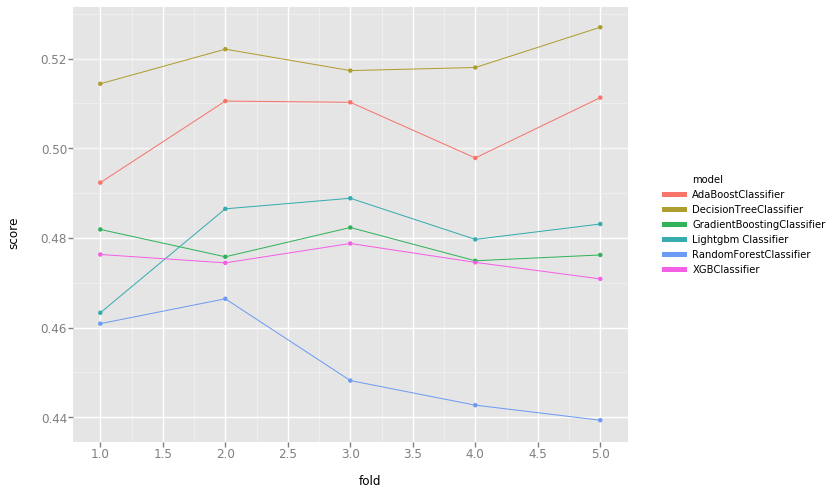

<ggplot: (-9223372036568180564)>


In [46]:
#create a small df with the scores
performance = pd.concat([ans,lgb_ans])
g_normal = ggplot(performance,aes(x='fold',y='score',group = 'model',color = 'model')) + geom_point() + geom_line()
print(g_normal)

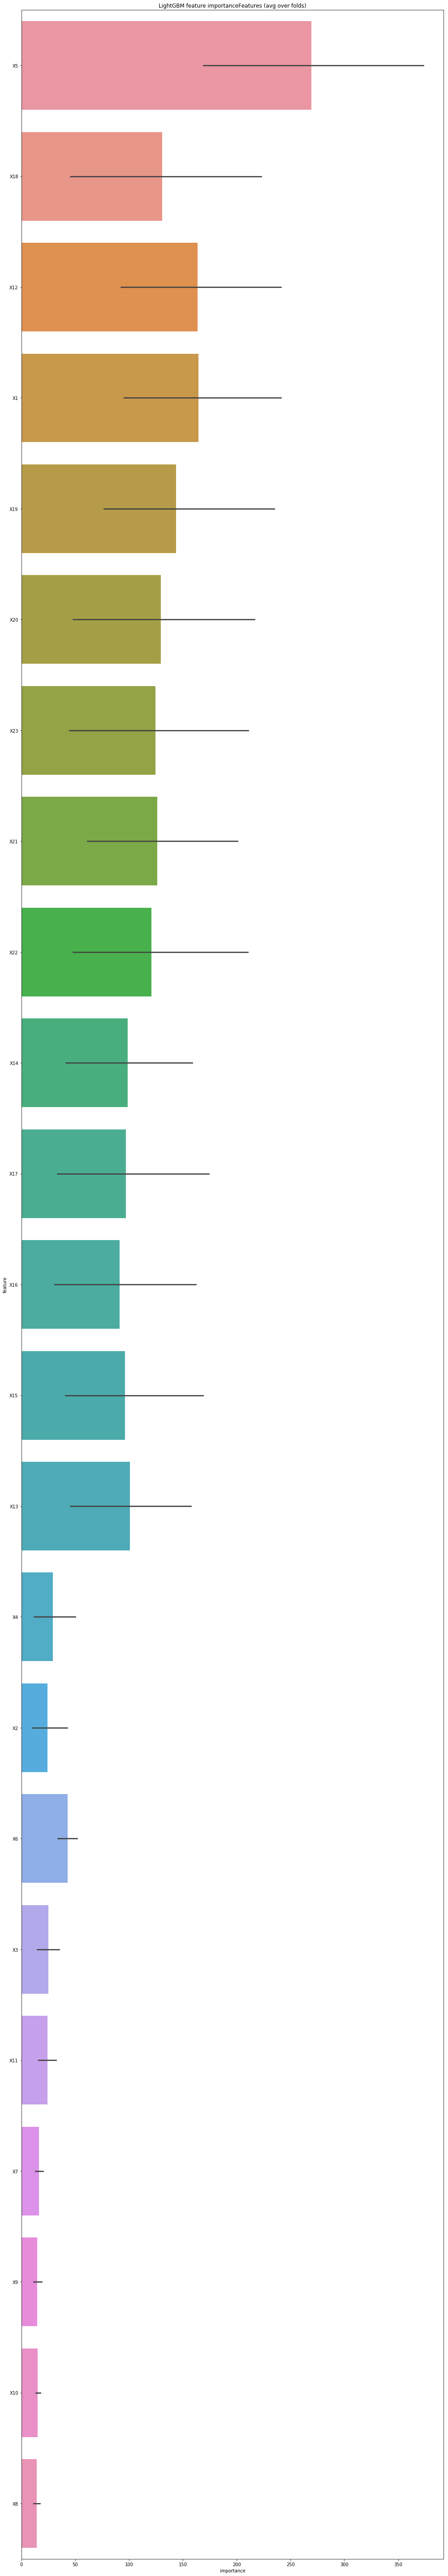

In [19]:
# create lightgbm importance display
LightGBM.display_importances(importances, title="LightGBM feature importance")

# Parameter tuning (optune)

## Lightgbm

lightgbm を例にして, パラメータチューニング

In [39]:
# tuning
study = optuna.create_study()
data = partial(LightGBM.tuning, train, features, category_features)
study.optimize(data, n_trials=10)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:05:11,437] Finished trial#0 resulted in value: 1.0. Current best value is 1.0 with parameters: {'boosting': 'gbdt', 'num_leaves': 10, 'learning_rate': 3.133714846739265e-06}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:07:42,311] Finished trial#1 resulted in value: 1.0. Current best value is 1.0 with parameters: {'boosting': 'gbdt', 'num_leaves': 10, 'learning_rate': 3.133714846739265e-06}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0523611	valid_1's binary_error: 0.180926
[200]	training's binary_error: 0.0104167	valid_1's binary_error: 0.183148
Early stopping, best iteration is:
[36]	training's binary_error: 0.134028	valid_1's binary_error: 0.178148
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0543056	valid_1's binary_error: 0.182778
[200]	training's binary_error: 0.011713	valid_1's binary_error: 0.181852
Early stopping, best iteration is:
[43]	training's binary_error: 0.12463	valid_1's binary_error: 0.177222
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0502778	valid_1's binary_error: 0.184259
[200]	training's binary_error: 0.0105093	valid_1's binary_error: 0.187593
Early stopping, best iteration is:
[47]	training's binary_error: 0.120602	valid_1's binary_error: 0.181111
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0533333	valid_1's binary_error: 0.190741
[200]	training's binary_error: 0.0108333	valid_1's binary_error: 0.19
Early stopping, best iteration is:
[53]	training's binary_error: 0.111111	valid_1's binary_error: 0.188333
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0513426	valid_1's binary_error: 0.183333
[200]	training's binary_error: 0.00930556	valid_1's binary_error: 0.18537
[300]	training's binary_error: 0.00342593	valid_1's binary_error: 0.182593
[400]	training's binary_error: 0.00185185	valid_1's binary_error: 0.185926
Early stopping, best iteration is:
[298]	training's binary_error: 0.00347222	valid_1's binary_error: 0.181852


[I 2019-04-21 01:09:03,794] Finished trial#2 resulted in value: 0.5300235655822407. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:11:06,753] Finished trial#3 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:13:34,115] Finished trial#4 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:17:20,700] Finished trial#5 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000787037	valid_1's binary_error: 0.199815
[200]	training's binary_error: 0.000787037	valid_1's binary_error: 0.198333
Early stopping, best iteration is:
[1]	training's binary_error: 0.168519	valid_1's binary_error: 0.188519
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000740741	valid_1's binary_error: 0.19463
[200]	training's binary_error: 0.000740741	valid_1's binary_error: 0.193333
Early stopping, best iteration is:
[45]	training's binary_error: 0.000740741	valid_1's binary_error: 0.193519
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000555556	valid_1's binary_error: 0.199074
[200]	training's binary_error: 0.000555556	valid_1's binary_error: 0.200556
Early stopping, best iteration is:
[2]	training's binary_error: 0.144583	valid_1's binary_error: 0.195
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000555556	valid_1's binary_error: 0.204815
[200]	training's binary_error: 0.000555556	valid_1's binary_error: 0.20463
Early stopping, best iteration is:
[37]	training's binary_error: 0.000555556	valid_1's binary_error: 0.202222
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.000601852	valid_1's binary_error: 0.193148
[200]	training's binary_error: 0.000601852	valid_1's binary_error: 0.196296
Early stopping, best iteration is:
[42]	training's binary_error: 0.000601852	valid_1's binary_error: 0.200185


[I 2019-04-21 01:18:43,028] Finished trial#6 resulted in value: 0.5660410356626291. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:21:18,841] Finished trial#7 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
[200]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889
Early stopping, best iteration is:
[1]	training's binary_error: 0.222778	valid_1's binary_error: 0.218889


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
[200]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481
Early stopping, best iteration is:
[1]	training's binary_error: 0.22213	valid_1's binary_error: 0.221481


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
[200]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444
Early stopping, best iteration is:
[1]	training's binary_error: 0.222639	valid_1's binary_error: 0.219444


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
[200]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593
Early stopping, best iteration is:
[1]	training's binary_error: 0.220602	valid_1's binary_error: 0.227593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
[200]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593
Early stopping, best iteration is:
[1]	training's binary_error: 0.221852	valid_1's binary_error: 0.222593


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
[I 2019-04-21 01:23:04,894] Finished trial#8 resulted in value: 1.0. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0823611	valid_1's binary_error: 0.183889
[200]	training's binary_error: 0.00912037	valid_1's binary_error: 0.184444
Early stopping, best iteration is:
[74]	training's binary_error: 0.113009	valid_1's binary_error: 0.182778
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0813889	valid_1's binary_error: 0.179444
[200]	training's binary_error: 0.00884259	valid_1's binary_error: 0.180741
[300]	training's binary_error: 0.0037037	valid_1's binary_error: 0.182037
Early stopping, best iteration is:
[149]	training's binary_error: 0.0273611	valid_1's binary_error: 0.176852
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0815741	valid_1's binary_error: 0.18463
[200]	training's binary_error: 0.00907407	valid_1's binary_error: 0.184444
Early stopping, best iteration is:
[58]	training's binary_error: 0.130093	valid_1's binary_error: 0.182407
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0786574	valid_1's binary_error: 0.187593
[200]	training's binary_error: 0.00925926	valid_1's binary_error: 0.190926
Early stopping, best iteration is:
[83]	training's binary_error: 0.100741	valid_1's binary_error: 0.186481
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.079537	valid_1's binary_error: 0.186111
[200]	training's binary_error: 0.00916667	valid_1's binary_error: 0.186481
Early stopping, best iteration is:
[80]	training's binary_error: 0.103287	valid_1's binary_error: 0.183889


[I 2019-04-21 01:25:54,832] Finished trial#9 resulted in value: 0.5548632536542228. Current best value is 0.5300235655822407 with parameters: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}.


In [42]:
# best params
print('Number of finished trials: {}'.format(len(study.trials)))
print('best value: {}'.format(study.best_trial.value))
print('Lightgbm Best params:', study.best_params)

Number of finished trials: 10
best value: 0.5300235655822407
params: {'boosting': 'gbdt', 'num_leaves': 227, 'learning_rate': 0.05948978672025942}


In [44]:
# using best parameters
ans = LightGBM.prediction(train,test,features,category_features,study.best_params)

fold n°1


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0523611	valid_1's binary_error: 0.180926
[200]	training's binary_error: 0.0104167	valid_1's binary_error: 0.183148
Early stopping, best iteration is:
[36]	training's binary_error: 0.134028	valid_1's binary_error: 0.178148
fold n°2


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0543056	valid_1's binary_error: 0.182778
[200]	training's binary_error: 0.011713	valid_1's binary_error: 0.181852
Early stopping, best iteration is:
[43]	training's binary_error: 0.12463	valid_1's binary_error: 0.177222
fold n°3


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0502778	valid_1's binary_error: 0.184259
[200]	training's binary_error: 0.0105093	valid_1's binary_error: 0.187593
Early stopping, best iteration is:
[47]	training's binary_error: 0.120602	valid_1's binary_error: 0.181111
fold n°4


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0533333	valid_1's binary_error: 0.190741
[200]	training's binary_error: 0.0108333	valid_1's binary_error: 0.19
Early stopping, best iteration is:
[53]	training's binary_error: 0.111111	valid_1's binary_error: 0.188333
fold n°5


/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:1042: UserWarning: categorical_feature in Dataset is overridden. New categorical_feature is [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
  warnings.warn('categorical_feature in Dataset is overridden. New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/Users/takuto/.pyenv/versions/anaconda3-5.1.0/envs/py3.6.5/lib/python3.6/site-packages/lightgbm/basic.py:685: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
/Users/takuto/.pyenv/version

Training until validation scores don't improve for 200 rounds.
[100]	training's binary_error: 0.0513426	valid_1's binary_error: 0.183333
[200]	training's binary_error: 0.00930556	valid_1's binary_error: 0.18537
[300]	training's binary_error: 0.00342593	valid_1's binary_error: 0.182593
[400]	training's binary_error: 0.00185185	valid_1's binary_error: 0.185926
Early stopping, best iteration is:
[298]	training's binary_error: 0.00347222	valid_1's binary_error: 0.181852


In [109]:
# target rate
print('train data rate:', Counter(train['y']))
print('test data rate:', Counter(ans))
# sample submit
# Process.submit(ans,tech="lightgbm_optuna")

## Decision Tree

In [79]:
# tuning
study = optuna.create_study()
data = partial(DecisionTree.tuning, train, features)
study.optimize(data, n_trials=50)

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:17,406] Finished trial#0 resulted in value: 0.5687029319057142. Current best value is 0.5687029319057142 with parameters: {'max_depth': 15, 'criterion': 'gini', 'min_samples_leaf': 10}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:18,991] Finished trial#1 resulted in value: 0.5278003075647675. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:19,820] Finished trial#2 resulted in value: 0.5289112597876067. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:20,124] Finished trial#3 resulted in value: 0.5437336954596547. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:21,239] Finished trial#4 resulted in value: 0.5337263489397872. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:23,478] Finished trial#5 resulted in value: 0.5807645855474122. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:25,392] Finished trial#6 resulted in value: 0.5404208180697777. Current best value is 0.5278003075647675 with parameters: {'max_depth': 8, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:26,056] Finished trial#7 resulted in value: 0.5275531299781745. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:27,493] Finished trial#8 resulted in value: 0.5285236213204725. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:29,047] Finished trial#9 resulted in value: 0.5403176387044647. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:29,593] Finished trial#10 resulted in value: 0.5304235689542549. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:29,857] Finished trial#11 resulted in value: 0.5555320184248534. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:31,708] Finished trial#12 resulted in value: 0.555583848732332. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:32,506] Finished trial#13 resulted in value: 0.5284480932182719. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:34,210] Finished trial#14 resulted in value: 0.5612387099930892. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:34,982] Finished trial#15 resulted in value: 0.5363732029746762. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:35,237] Finished trial#16 resulted in value: 0.5555320184248534. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:36,623] Finished trial#17 resulted in value: 0.5294638230539409. Current best value is 0.5275531299781745 with parameters: {'max_depth': 4, 'criterion': 'gini', 'min_samples_leaf': 4}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:37,889] Finished trial#18 resulted in value: 0.5265323461920629. Current best value is 0.5265323461920629 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:38,972] Finished trial#19 resulted in value: 0.5230564144276301. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:40,063] Finished trial#20 resulted in value: 0.5230564144276301. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:42,165] Finished trial#21 resulted in value: 0.542680824415215. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:43,268] Finished trial#22 resulted in value: 0.5232217299452945. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:45,012] Finished trial#23 resulted in value: 0.5364816859894994. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:45,642] Finished trial#24 resulted in value: 0.5468557843672459. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:47,239] Finished trial#25 resulted in value: 0.5319840330124079. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:49,879] Finished trial#26 resulted in value: 0.5595126415343228. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:51,910] Finished trial#27 resulted in value: 0.5414274643209207. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:53,003] Finished trial#28 resulted in value: 0.5292671889170134. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:53,452] Finished trial#29 resulted in value: 0.56079788344381. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:55,237] Finished trial#30 resulted in value: 0.5350211755421738. Current best value is 0.5230564144276301 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 1}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:56,408] Finished trial#31 resulted in value: 0.5230051646951909. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:57,028] Finished trial#32 resulted in value: 0.5468557843672459. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:58,663] Finished trial#33 resulted in value: 0.5327121142598384. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 12:59:59,599] Finished trial#34 resulted in value: 0.5302864712207137. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:02,380] Finished trial#35 resulted in value: 0.5763602385949218. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:03,695] Finished trial#36 resulted in value: 0.5232835336393455. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:06,290] Finished trial#37 resulted in value: 0.5595126415343228. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:06,773] Finished trial#38 resulted in value: 0.56079788344381. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:08,870] Finished trial#39 resulted in value: 0.5414274643209207. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:10,614] Finished trial#40 resulted in value: 0.5327121142598384. Current best value is 0.5230051646951909 with parameters: {'max_depth': 6, 'criterion': 'entropy', 'min_samples_leaf': 2}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:11,919] Finished trial#41 resulted in value: 0.5214379682359338. Current best value is 0.5214379682359338 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 6}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:12,553] Finished trial#42 resulted in value: 0.5276167411147487. Current best value is 0.5214379682359338 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 6}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:13,845] Finished trial#43 resulted in value: 0.5214379682359338. Current best value is 0.5214379682359338 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 6}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:15,293] Finished trial#44 resulted in value: 0.5395968356765317. Current best value is 0.5214379682359338 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 6}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:16,584] Finished trial#45 resulted in value: 0.5205846634597727. Current best value is 0.5205846634597727 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:18,406] Finished trial#46 resulted in value: 0.5568649034953409. Current best value is 0.5205846634597727 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:20,770] Finished trial#47 resulted in value: 0.5667653446030527. Current best value is 0.5205846634597727 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:21,890] Finished trial#48 resulted in value: 0.5342425441114632. Current best value is 0.5205846634597727 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}.


fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


[I 2019-04-21 13:00:23,867] Finished trial#49 resulted in value: 0.5482577686771003. Current best value is 0.5205846634597727 with parameters: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}.


In [80]:
# best params
print('Number of finished trials: {}'.format(len(study.trials)))
print('best value: {}'.format(study.best_trial.value))
print('Dicision Tree best params:', study.best_params)

Number of finished trials: 50
best value: 0.5205846634597727
Dicision Tree best params: {'max_depth': 7, 'criterion': 'entropy', 'min_samples_leaf': 9}


In [85]:
# using best parameters
ans = DecisionTree.prediction(train,test,features,study.best_params)

fold n°1
fold n°2
fold n°3
fold n°4
fold n°5


In [36]:
# target rate
print('train data rate:', Counter(train['y']))
print('test data rate:', Counter(ans))
# sample submit
# Process.submit(ans,tech="decisiontree_optuna")

train data rate: Counter({0: 21006, 1: 5994})


NameError: name 'ans' is not defined

# other technic

## Down sampling

- 二値分類において, 偏りがある場合少数データに合わせて, 偏りをなくす方法

In [42]:
Applicate.down_sampling(train,features,rate=3)

original data rate: Counter({0: 21006, 1: 5994})
down sampling data rate: Counter({0: 17982, 1: 5994})


,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,y
0,90000,2,2,1,47,0,0,0,0,0,...,28747,29177,29452,2000,2000,2000,2000,2000,2000,0
1,150000,2,1,1,36,-2,-2,-2,-2,-2,...,25172,4694,6292,13447,17914,25349,4694,6324,14433,0
2,30000,1,3,1,48,-1,-1,-1,-1,-1,...,1261,1261,1261,1261,1261,1261,1261,1261,1261,0
3,30000,2,3,1,47,1,2,2,2,0,...,14369,15333,16289,1000,900,1000,1200,1200,1200,0
4,320000,2,2,2,33,0,0,0,0,0,...,65913,43805,33263,10042,18832,2117,2076,5045,3754,0
5,70000,2,2,1,33,0,0,0,0,0,...,10681,7431,4705,1683,3160,3000,3000,5060,5032,0
6,280000,1,1,2,30,1,2,2,0,0,...,153063,133490,130377,1000,7600,5949,6000,5200,5117,0
7,20000,1,3,2,24,0,0,0,0,-1,...,3486,199,0,2000,1000,400,199,0,0,0
8,140000,2,2,2,27,0,0,0,0,0,...,92381,83641,86316,6000,4000,4000,3000,4000,4000,0
9,80000,1,1,2,33,0,0,0,0,-2,...,-2639,-2787,34732,5000,14016,0,2000,38000,6000,0
